<a href="https://colab.research.google.com/github/ellagattis/kuka/blob/main/not_aligned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set up


In [ ]:
#pip installs i need
%%capture
!pip install control
!pip install pandas
!pip install ipympl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports needed
import pickle
import numpy as np
import matplotlib.pyplot as plt
import control
import fnmatch
import os
import random
from scipy.spatial import distance
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/content/drive/My Drive/msci_project/')
import kuka_combine as kc

%matplotlib inline

In [ ]:
#load the echo object
date = '20200116'
bandwidth = 'full_bw' 
test = pickle.load(open("/content/drive/My Drive/msci_project/kuka_stare_"+date+"_"+bandwidth+".p", "rb")) 

In [ ]:
#load magnaprobe data
mfile_path = '/content/drive/My Drive/msci_project/magna_xy/'
date = '20200116'
mf = fnmatch.filter(os.listdir(mfile_path),'*'+date+'*')
print('mf',mf)
mf = mf[0] # want PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv (N+S combined)
print('mf',mf)
mag = pd.read_csv(mfile_path+mf)

mf ['PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanS-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33_cleanN-20200116-UTC-0.csv', 'PS122-2_20-95-ANJA_33-20200116-UTC-0.csv']
mf PS122-2_20-95-ANJA_33_clean-20200116-UTC-0.csv


In [ ]:
# slice echo to just range 1-3 metres
yrange = 1,3

ku_r0 = np.where(abs(test.ku_rg[:,0]-yrange[0]) == min(abs(test.ku_rg[:,0]-yrange[0])))[0]
ku_r1 = np.where(abs(test.ku_rg[:,0]-yrange[1]) == min(abs(test.ku_rg[:,0]-yrange[1])))[0]
ka_r0 = np.where(abs(test.ka_rg[:,0]-yrange[0]) == min(abs(test.ka_rg[:,0]-yrange[0])))[0]
ka_r1 = np.where(abs(test.ka_rg[:,0]-yrange[1]) == min(abs(test.ka_rg[:,0]-yrange[1])))[0]
ku_r0 = ku_r0[0]
ku_r1 = ku_r1[0]
ka_r0 = ka_r0[0]
ka_r1 = ka_r1[0]

pixels_per_m_ku = (ku_r1 - ku_r0)/(yrange[1] - yrange[0]) #pixels per metre
pixels_per_m_ka = (ka_r1 - ka_r0)/(yrange[1] - yrange[0]) #pixels per metre

print('ku_r0,ku_r1,ka_r0,ka_r1',ku_r0,ku_r1,ka_r0,ka_r1)

#select just elements within depth range and convert to dB
ku_vv_echo = control.mag2db(test.ku_vv[ku_r0:ku_r1,:])
ku_vh_echo = control.mag2db(test.ku_vh[ku_r0:ku_r1,:])
ku_hv_echo = control.mag2db(test.ku_hv[ku_r0:ku_r1,:])
ku_hh_echo = control.mag2db(test.ku_hh[ku_r0:ku_r1,:])

ka_vv_echo = control.mag2db(test.ka_vv[ka_r0:ka_r1,:])
ka_vh_echo = control.mag2db(test.ka_vh[ka_r0:ka_r1,:])
ka_hv_echo = control.mag2db(test.ka_hv[ka_r0:ka_r1,:])
ka_hh_echo = control.mag2db(test.ka_hh[ka_r0:ka_r1,:])

ku_r0,ku_r1,ka_r0,ka_r1 442 704 671 1108


In [ ]:
# functions to split into northern and southern transect
ku_south = np.where(test.ku_y > 0)[0]
ku_north = np.where(test.ku_y < 0)[0]

ka_south = np.where(test.ka_y > 0)[0]
ka_north = np.where(test.ka_y < 0)[0]

def south_ku(echo):
  south_echo = control.mag2db(echo[ku_r0:ku_r1,ku_south])
  return south_echo

def north_ku(echo):
  north_echo = control.mag2db(echo[ku_r0:ku_r1,ku_north])
  return north_echo

def south_ka(echo):
  south_echo = control.mag2db(echo[ka_r0:ka_r1,ka_south])
  return south_echo

def north_ka(echo):
  north_echo = control.mag2db(echo[ka_r0:ka_r1,ka_north])
  return north_echo

# nearest neighbour search

In [ ]:
#use scipy's cdist function to find closest magnaprobe point for one kuka point
def closest_point(point, magna_points):
    magna_locations = (magna_points.xc, magna_points.yc)
    magna_locations = (np.transpose(magna_locations))
    closest_index = (distance.cdist([point], magna_locations)).argmin()
    #result = np.count_nonzero(dist_matrix<=r)
    return magna_points.iloc[closest_index]

In [ ]:
#ku nearest neighbours 
ku_closest_points_list = pd.DataFrame()
ku_loc = (test.ku_x, test.ku_y)
ku_loc = np.transpose(ku_loc)

for i in range(len(ku_loc)):
  mag_cp = closest_point(ku_loc[i], mag)
  ku_closest_points_list = ku_closest_points_list.append(mag_cp)

#scale magnaprobe depths by 0.8 to account for velocity change in snow - not needed for NN
# ku_scaled_mag_depths = ku_closest_points_list.DepthCm*0.7

In [ ]:
#ka nearest neighbours
ka_closest_points_list = pd.DataFrame()
ka_loc = (test.ka_x, test.ka_y)
ka_loc = np.transpose(ka_loc)

for i in range(len(ka_loc)):
  mag_cp = closest_point(ka_loc[i], mag)
  ka_closest_points_list = ka_closest_points_list.append(mag_cp)

#scale magnaprobe depths by 0.8 to account for velocity change in snow
ka_scaled_mag_depths = ka_closest_points_list.DepthCm*0.8

# filter echoes for repetition

In [ ]:
#calculate Ku mask 

temp=np.transpose(ku_vv_echo) # transpose so that mvmt along transect is in y direction
temp1=np.roll(temp,shift=1,axis=0)
diff=temp1-temp
std=[]
for i in range (np.transpose(ku_vv_echo).shape[0]):
    std.append(np.sum(diff[i,:]**2))
 
mask_ku=np.outer(np.asarray(std),np.ones((262))) # outer product w/ ones to create 2d array
mask_ku[mask_ku<10000]=np.nan
mask_ku[mask_ku>=10000]=1.
# mask_ku[:,1300]


#calculate Ka mask

temp=np.transpose(ka_vv_echo)
temp1=np.roll(temp,shift=1,axis=0)
diff=temp1-temp
std=[]
for i in range (np.transpose(ka_vv_echo).shape[0]):
    std.append(np.sum(diff[i,:]**2))

mask_ka=np.outer(np.asarray(std),np.ones((437)))
mask_ka[mask_ka<20000]=np.nan
mask_ka[mask_ka>=20000]=1.
# mask[:,1300]    

In [ ]:
#filter Ku
ku_vv_masked = np.transpose(ku_vv_echo)[:]*mask_ku[:]
ku_vv_filtered = ku_vv_masked[~np.isnan(ku_vv_masked).any(axis=1),:]

ku_hh_masked = np.transpose(ku_hh_echo)[:]*mask_ku[:]
ku_hh_filtered = ku_hh_masked[~np.isnan(ku_hh_masked).any(axis=1),:]

ku_hv_masked = np.transpose(ku_hv_echo)[:]*mask_ku[:]
ku_hv_filtered = ku_hv_masked[~np.isnan(ku_hv_masked).any(axis=1),:]

ku_vh_masked = np.transpose(ku_vh_echo)[:]*mask_ku[:]
ku_vh_filtered = ku_vh_masked[~np.isnan(ku_vh_masked).any(axis=1),:]

#filter Ka
ka_vv_masked = np.transpose(ka_vv_echo)[:]*mask_ka[:]
ka_vv_filtered = ka_vv_masked[~np.isnan(ka_vv_masked).any(axis=1),:]

ka_hh_masked = np.transpose(ka_hh_echo)[:]*mask_ka[:]
ka_hh_filtered = ka_hh_masked[~np.isnan(ka_hh_masked).any(axis=1),:]

ka_hv_masked = np.transpose(ka_hv_echo)[:]*mask_ka[:]
ka_hv_filtered = ka_hv_masked[~np.isnan(ka_hv_masked).any(axis=1),:]

ka_vh_masked = np.transpose(ka_vh_echo)[:]*mask_ka[:]
ka_vh_filtered = ka_vh_masked[~np.isnan(ka_vh_masked).any(axis=1),:]

In [ ]:
ku_scaled_mag_depths_m = ku_scaled_mag_depths[~np.isnan(ku_vv_masked).any(axis=1)]
ka_scaled_mag_depths_m = ka_scaled_mag_depths[~np.isnan(ka_vv_masked).any(axis=1)]

# filter echoes for large tilt

# building & training neural network

In [ ]:
# https://github.com/kapil-varshney/utilities/blob/master/training_plot/training_plot_ex_with_cifar10.ipynb
class TrainingPlot(keras.callbacks.Callback):
   
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(15,10))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.title("Training Loss [Epoch {}]".format(epoch), size = 35)
            plt.xlabel("Epoch #", size = 30)
            plt.ylabel("Loss", size = 30)
            plt.legend(prop={'size':20})
            plt.show()

plot_losses = TrainingPlot()

In [ ]:
#callback to reduce learning rate when loss plateaus for 5 epochs
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00005)

In [ ]:
# stop the training when there is no improvement in  the validation loss for ten consecutive epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
my_callbacks = [plot_losses, reduce_lr, early_stop]

In [ ]:
#whatever combination we want as input
ka_vv_hv = (ka_vv_filtered)[:] + 3*(ka_hv_filtered)[:]
ku_vv_hv = (ku_vv_filtered)[:] + 3*(ku_hv_filtered)[:] 

In [ ]:
#Normalize
sc = StandardScaler()
Ku_normalized = sc.fit_transform(ku_vv_hv)
Ka_normalized = sc.fit_transform(ka_vv_hv)

In [ ]:
# for conv1d ONLY reshape data to (number of samples, number of channels, length of 1 echo)
#Ka_normalized = Ka_normalized.reshape(Ka_normalized.shape[0], 1, Ka_normalized.shape[1])

In [ ]:
# training & testing data, and shuffle
#Ka_train, Ka_test, mag_train, mag_test, index_train, index_test = train_test_split(Ka_normalized, ka_scaled_mag_depths_m, np.arange(0, len(Ka_normalized)), random_state=1)
Ku_train, Ku_test, mag_train, mag_test, index_train, index_test = train_test_split(Ku_normalized, ku_scaled_mag_depths_m, np.arange(0, len(Ku_normalized)), random_state=1)

In [ ]:
#polynomial decay learning rate scheduler
starter_learning_rate = 0.01
end_learning_rate = 0.00005
decay_steps = 1000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
     starter_learning_rate,
         decay_steps,
             end_learning_rate,
                 power=0.5)

#piecewise decay learning rate scheduler
#step = tf.Variable(0, trainable=False)
#boundaries = [100000, 110000]
#values = [0.00002, 0.000005, 0.00001]
#learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
#learning_rate = learning_rate_fn(step)

In [ ]:
# build model
model = keras.Sequential()

# a sampling frequency - these are only needed for CNN
fs = 250
kernel_time = 4

ka_shape = (437,)
ku_shape  = (262,)

model.add(keras.Input(shape = ku_shape)) # comment out this line & uncomment conv1d lines for CNN
model.add(keras.layers.Dropout(0.2))
#model.add(keras.layers.Conv1D(filters     = 1,         # 1 output per sample
#                 kernel_size = fs * kernel_time,       #convolution window size
#                 activation  ='linear', 
#                 input_shape = (20, 1, 437),           #input shape = (batch_size, steps/channels, input_dim)
#                 padding     = 'same'))
model.add(keras.layers.Dense(32, activation = 'sigmoid'))
#model.add(keras.layers.Dense(64, activation = 'relu'))
#model.add(keras.layers.Dense(64, activation = 'tanh'))
model.add(keras.layers.Dense(1, activation='relu'))

model.summary() # this line gives problems for CNN for some reason so just comment it out when using conv1d

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 262)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8416      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='mean_squared_error')

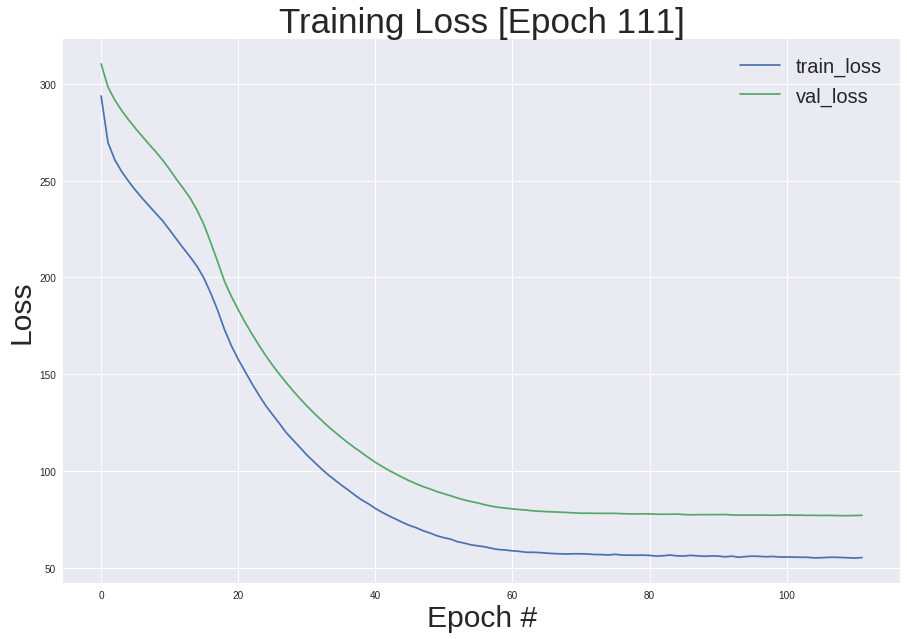

Epoch 113/500
  1/165 [..............................] - ETA: 1s - loss: 58.6771

KeyboardInterrupt: ignored

In [ ]:
# fit network
N_epochs = 500
                  # change to relevant Ku/Ka
history = model.fit(x = Ku_train, y = mag_train, epochs = N_epochs, 
                    validation_split = 0.1, callbacks=[plot_losses], batch_size=20)

In [ ]:
# evaluate model
predictions  = model.predict(Ku_test)
mag_test     = np.asarray(mag_test).flatten()
predictions  = predictions.flatten()

In [ ]:
#unshuffle the data for clearer plots
sort_array = np.vstack((index_test, mag_test, predictions))
sortedArr = sort_array [ :, sort_array[0].argsort()]

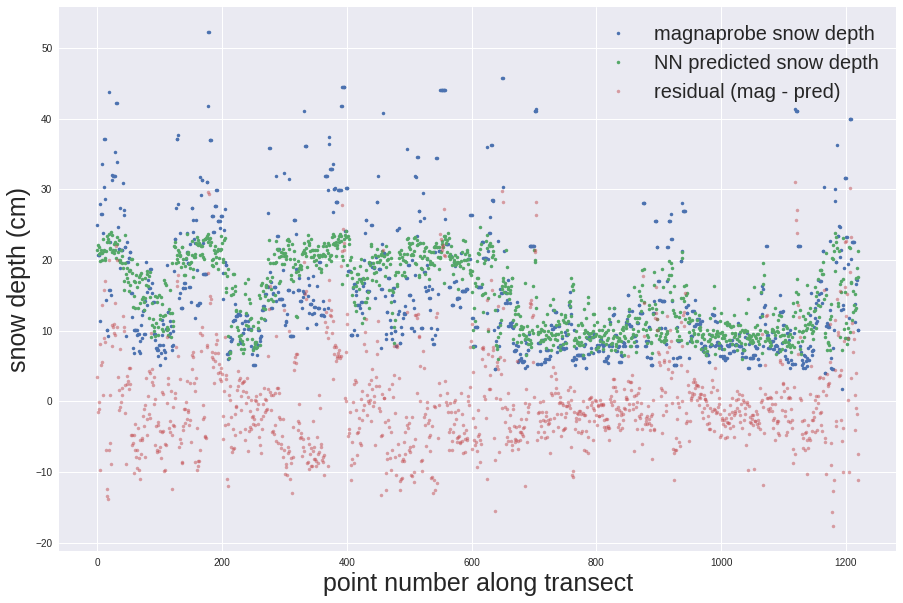

In [ ]:
# Make the plot.
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, len(mag_test), 1), sortedArr[1], '.', linewidth=1.75, label = 'magnaprobe snow depth')
plt.plot(np.arange(0, len(mag_test), 1), sortedArr[2], '.', linewidth=1.75, label ='NN predicted snow depth')
plt.plot(np.arange(0, len(mag_test), 1), sortedArr[1]-sortedArr[2], '.', linewidth=1.75, label = 'residual (mag - pred)', alpha=0.5)
plt.xlabel('point number along transect', size = 25)
plt.ylabel('snow depth (cm)', size = 25)

plt.legend(prop={'size':20})
plt.grid(True)
plt.show()

pearson correlation:  0.5903968188394186


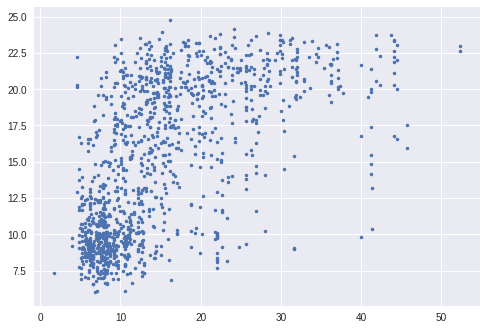

In [ ]:
plt.plot(mag_test, predictions, '.')
print('pearson correlation: ', np.corrcoef(mag_test, predictions)[0, 1])